In [1]:
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import time as t

In [2]:
import pandas as pd
import sys
from env_pybullet_gen3 import env_pybullet_kin_gen3



In [3]:
#To improve the velocity, run it on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device ', device)



#Create a experiment env
env = env_pybullet_kin_gen3(no_zeros = True,Excel_path_Okay_tcp = "./positions_from_joints_19.xlsx",time_step=0.05,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Initially parameters of the urdf

#Make maxvels closer to the reality
#both have to be modified
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
print(env.original_parameters_df["max_vel"])
print(env.original_parameters_df)


print('observation space:', env.observation_space) #states, There is only 1 state constant
env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz"])
print('action space:', env.action_space) #parameters, number of parameters choose to tune, continuous
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous




Device  cpu
hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
0    168
1    151
2    128
3     94
4    210
5     48
6    189
Name: max_vel, dtype: int64
       mass damping       Ixx       Iyy       Izz   kp   ki   kd  max_vel  \
0  1.377353       0  0.004801  0.004755  0.002283  0.1  0.0  0.0      168   
1  1.163667       0  0.008419  0.001920  0.008361  0.1  0.0  0.0      151   
2  1.163660       0  0.007545  0.007487  0.001921  0.1  0.0  0.0      128   
3  0.930287       0  0.006410  0.001380  0.006518  0.1  0.0  0.0       94   
4  0.678106       0  0.001680  0.001506  0.000826  0.1  0.0  0.0      210   
5  0.678106       0  0.001938  0.000827  0.001763  0.1  0.0  0.0       48   
6  0.500657       0  0.000775  0.000585  0.000975  0.1  0.0  0.0      189   

   force_x_one  
0            1  
1            1  
2            1  
3            1  
4            1  
5            1  
6            1  
observation space: 1
mass okey
max_vel okey
kp o

In [4]:
#Cross Entrophy Method, to choose the weights

# In my case where only 1 action,and that it's apply the parameters do another step doesn't change anything due to the state doesn't vary
# For this reason max_t and gama doesn't make sense, so I set them to max_t = 1 and gamma to 0
def cem_no_net(n_iterations=700, max_t=1, gamma=0.0, print_every=50, pop_size=env.action_space, elite_frac=10/(env.action_space*2), sigma=0.3,sigma_reduction_every_print = 0.65, per_one = True ):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
        per_one (boolean): to determine if the output is in per one or not
    """
    #Numbers of elements that you keep as the better ones
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from iterations size * 0.1
    scores_deque = deque(maxlen=int(n_iterations*0.1))
    #intial scores empty
    scores = []
    #Save actions to see how they evolve
    best_actions = []
    #Select a seed to make the results the same every test, not depending on the seed
    np.random.seed(0)
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    
    if (per_one == True):
        best_weight = sigma*np.random.randn(env.action_space)
        original_action = np.array(env.action_original())
    else:
        best_weight = np.add(sigma*np.random.randn(env.action_space),env.action_original())

    #Each iteration, modify  + (from 0 to 1) the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    
    for i_iteration in range(1, n_iterations+1):
        
        #Generate new population weights, as a mutation of the best weight to test them
        weights_pop = [best_weight + (sigma*np.random.randn(env.action_space)) for i in range(pop_size)]
        
        #Compute the parameters and obtain the rewards for each of them
        #print("iteration "+str(i_iteration))
        if (per_one == True):
            rewards=[]
            for weights in weights_pop:
                #print("New weights")
                #print(weights)
                #t.sleep(1000)
                action=np.add(np.multiply(weights,original_action),original_action)
                rewards.append( env.step_tcp_rishabh(action) )
            rewards = np.array(rewards)
        else:
            rewards=[]
            for weights in weights_pop:
                rewards.append(env.step_tcp_rishabh(weights) )
            rewards = np.array(rewards)
        print("rewards" + str(i_iteration))
        print(rewards)
        #print("\n")
        
        #Sort the rewards to obtain the best ones
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        #Set the best weight as the mean of the best ones 
       
        best_weight = np.array(elite_weights).mean(axis=0)
        
        #Get the reward with this new weight
        
        if (per_one == True):
            action = np.add(np.multiply(best_weight,original_action),original_action)
            #print("action vel")
            #print(action[8])
            #print("action kp")
            #print(action[15])
            #time.sleep(1000)
            best_actions.append(action)
            reward = env.step_tcp_rishabh(action)
            print("reward")
            print(reward)
            print("\n")
        else:
            best_actions.append(best_weight)
            reward = env.step_tcp_rishabh(best_weight)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        env.save_parameters("./Parameters_train_tcp_euc_rishabh.xlsx")
        
        if i_iteration % print_every == 0:
            sigma = sigma * sigma_reduction_every_print
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-n_iterations*0.1, np.mean(scores_deque)))
            break
    return scores,best_actions


rewards1
[-0.16397515 -0.28245656 -0.17721985 -0.16621907 -0.15203679 -0.27111682
 -0.22933904 -0.17850869 -0.17382578 -0.15260351 -0.25045082 -0.15665328
 -0.15505304 -0.18666162 -0.18071532 -0.23407996 -0.1801245  -0.15165878
 -0.24291922 -0.1623494  -0.16798387 -0.12790071 -0.18694454 -0.15637045
 -0.14879577 -0.15232597 -0.18251678 -0.24859745 -0.20067303 -0.26525601
 -0.20688806 -0.19095564 -0.18090049 -0.17862065 -0.1748199  -0.15024075
 -0.18638866 -0.20278096 -0.17812159 -0.15466958 -0.16383426 -0.14786135
 -0.23410482 -0.20201706 -0.20068485 -0.22603929 -0.17516261 -0.17693484
 -0.1747468  -0.16192645 -0.16512089 -0.17199096 -0.19613955 -0.17332991
 -0.14372354 -0.28094054 -0.16108797 -0.1536825  -0.43536958 -0.13662217
 -0.18750237 -0.1543218  -0.15458316]
reward
-0.15340520134665103


rewards2
[-0.1448248  -0.25428389 -0.18949537 -0.14887906 -0.1477281  -0.16535738
 -0.17268272 -0.14269907 -0.16584637 -0.16365152 -0.16066453 -0.14294508
 -0.14155905 -0.20197002 -0.16159327 -

rewards12
[-0.12607621 -0.19636513 -0.12779588 -0.16423728 -0.13259354 -0.1816036
 -0.12714912 -0.11418985 -0.09983417 -0.10904731 -0.1258296  -0.11642466
 -0.14900672 -0.12982882 -0.14503733 -0.10303582 -0.11263983 -0.12637391
 -0.11832818 -0.17442812 -0.14621062 -0.24671755 -0.15611722 -0.11480508
 -0.30427606 -0.11222626 -0.26926332 -0.12861471 -0.11283901 -0.10526144
 -0.1141764  -0.09179501 -0.10758275 -0.13578285 -0.10934399 -0.10608052
 -0.09004119 -0.13019792 -0.13118813 -0.12915381 -0.13197611 -0.10577132
 -0.13382748 -0.17067276 -0.1469593  -0.14991968 -0.12191272 -0.46273159
 -0.11310622 -0.14698365 -0.11517565 -0.11810096 -0.1353056  -0.16296183
 -0.10750479 -0.17958761 -0.09597213 -0.12049318 -0.1332472  -0.11257404
 -0.17937861 -0.13377253 -0.11543684]
reward
-0.10049175073934002


rewards13
[-0.10278643 -0.25127281 -0.1236992  -0.14061323 -0.13667622 -0.10465078
 -0.14386808 -0.10492899 -0.12479018 -0.08533358 -0.12377105 -0.11040859
 -0.12785718 -0.14175111 -0.13974155 

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
reward
-0.12042734341545112


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations r

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
reward
-0.12330743661663743


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations r

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
reward
-0.0929308028362349


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations re

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
reward
-0.2742922518886919


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations re

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
reward
-0.2268586359540355


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations re

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards39
[-0.34189395 -0.36801004 -0.22568275 -0.29156635 -0.24450372 -0.40569641
 -0.22821532 -0.23470505 -0.26195628 -0.26982059 -0.34921988 -0.34635578
 -0.33215307 -0.29872071 -0.23776186 -0.3193601  -0.49905251 -0.3076491
 -0.23315605 -0.26113626 -0.39551633 -0.22222022 -0.26350807 -0.26429446
 -0.33311099 -0.24936978 -0.28495619 -0.16904847 -0.42265025 -0.12477853
 -0.42537732 -0.19796454 -0.10810835 -0.13310965 -0.12267877 -0.31415965
 -0.23141106 -0.13133248 -0.

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards42
[-0.13347256 -0.25868218 -0.12240102 -0.15632578 -0.12502051 -0.1209485
 -0.1480296  -0.14287013 -0.09450071 -0.12704616 -0.11045176 -0.14552775
 -0.11464586 -0.60647375 -0.15288958 -0.11243484 -0.23573247 -0.11917649
 -0.11210518 -0.12393705 -0.11727759 -0.13335508 -0.09790914 -0.10100032
 -0.13399228 -0.12360091 -0.12396795 -0.12449079 -0.12339583 -0.1307403
 -0.10805897 -0.13532319 -0.11221609 -0.11399142 -0.1117831  -0.13112717
 -0.65537118 -0.10128956 -0.11857451 -0.13803773 -0.11948455 -0.12993301
 -0.14098591 -0.15797688 -0.59652855 -0.1318326  -0.77242627 -0.15967816
 -0.10316037 -0.14867976 -0.12954919 -0.11560218 -0.10559255 -0.11196716
 -0.15522244 -0.12453902 -0.1069226  -0.12017943 -0.12315012 -0.13708879
 -0.11363817

rewards51
[-0.0998268  -0.139879   -0.14870452 -0.14519113 -0.15805529 -0.11366927
 -0.11942329 -0.09864149 -0.09602503 -0.13996552 -0.09144689 -0.13277607
 -0.12618614 -0.11396869 -0.0951016  -0.10205368 -0.09751504 -0.10974529
 -0.1216565  -0.1206327  -0.16592059 -0.11118639 -0.12209771 -0.13812862
 -0.10351222 -0.10749526 -0.10244374 -0.14910265 -0.12055081 -0.1326882
 -0.18407984 -0.08750285 -0.13232104 -0.13783073 -0.10432764 -0.09561402
 -0.11553652 -0.10394362 -0.09497588 -0.11170498 -0.11747663 -0.11309284
 -0.11774843 -0.11851173 -0.09460522 -0.10005458 -0.10840313 -0.14536924
 -0.11950054 -0.1304565  -0.12010995 -0.1199059  -0.12304948 -0.13176162
 -0.09977509 -0.10518454 -0.15242621 -0.12506738 -0.17506502 -0.10044927
 -0.11798493 -0.13407879 -0.11398521]
reward
-0.10497550338762981


maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards52
[-0.10503593 -0.1227062  -0.13192396 -0.1384479  -0.14015064 -0.11087605
 -0.15930647 -0.11201969 -0.1199161

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards60
[-0.16762433 -0.10113115 -0.12755869 -0.10238866 -0.07754522 -0.11632075
 -0.0967113  -0.15207179 -0.1266387  -0.10140692 -0.16567853 -0.11246039
 -0.10213959 -0.109424   -0.08049503 -0.0852859  -0.0852336  -0.09338055
 -0.11896961 -0.10749294 -0.10381252 -0.11555189 -0.1115949  -0.10490527
 -0.11770356 -0.09891059 -0.09565316 -0.14133506 -0.11437175 -0.11854246
 -0.13309648 -0.1401335  -0.09875847 -0.11774955 -0.09541121 -0.19005983
 -0.11393794 -0.1459174  -0.09274296 -0.09834377 -0.07720277 -0.20962912
 -0.1001558  -0.12263978 -0.10733598 -0.16247979 -0.10303287 -0.10382258
 -0.11736174 -0.16165663 -0.1058219  -0.10008204 -0.1286057  -0.13108597
 -0.12331508 -0.09059035 -0.09928377 -0.09787632 -0.15731096 -0.11837502
 -0.11076271 -0.0968223  -0.1083151

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards70
[-0.09885166 -0.1199907  -0.08347807 -0.11589282 -0.09365827 -0.11062298
 -0.30785232 -0.10037855 -0.11693694 -0.11960578 -0.09819004 -0.09880292
 -0.12672002 -0.10794326 -0.10167114 -0.1273451  -0.11903007 -0.10460193
 -0.11060779 -0.1093189  -0.11065916 -0.08331929 -0.10543834 -0.1139736
 -0.12936071 -0.13388662 -0.0967364  -0.09814904 -0.10311571 -0.13246301
 -0.12818529 -0.10675238 -0.11132849 -0.0970633  -0.09824782 -0.12659327
 -0

maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach


reward
-0.09498185675824389


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations r

reward
-0.07806390786601003


maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards82
[-0.09237213 -0.07833944 -0.09943902 -0.11059209 -0.15615612 -0.08609388
 -0.11799803 -0.12057783 -0.09777809 -0.10727684 -0.15328114 -0.10848684
 -0.09147288 -0.11525018 -0.12898566 -0.12355858 -0.14242405 -0.10453228
 -0.11219033 -0.11552288 -0.15970313 -0.07709719 -0.11557281 -0.1049988
 -0.09785714 -0.11357602 -0.15380649 -0.08977429 -0.09956335 -0.12035682
 -0.13477843 -0.08784106 -0.08949809 -0.1386314  -0.1567812  -0.11628688
 -0.0896548  -0.12012741 -0.11360028 -0.12918779 -0.10305934 -0.09485041
 -0.1033146  -0.11458238 -0.12666636 -0.1499261  -0.14538439 -0.10497893
 -0.08485441 -0.09275396 -0

rewards92
[-0.07877546 -0.1306446  -0.07940551 -0.13375604 -0.09310426 -0.09405159
 -0.11365049 -0.08228729 -0.13944904 -0.0892612  -0.09210314 -0.09975548
 -0.10073845 -0.10881586 -0.11173585 -0.11588899 -0.09009219 -0.09853825
 -0.09605108 -0.08721239 -0.08319863 -0.13171553 -0.13971978 -0.13526246
 -0.11218639 -0.15243531 -0.09743608 -0.10548595 -0.12980567 -0.11021821
 -0.1094086  -0.12445082 -0.1113179  -0.09382853 -0.10870085 -0.1252863
 -0.1161083  -0.08529236 -0.18054321 -0.10914345 -0.14566667 -0.12476524
 -0.11923917 -0.10195831 -0.09332633 -0.12818075 -0.10216901 -0.09834297
 -0.08799663 -0.12602841 -0.09670436 -0.11320372 -0.14368733 -0.12649711
 -0.12694201 -0.10691698 -0.09416864 -0.13620483 -0.10766576 -0.13713042
 -0.08415049 -0.08234989 -0.10042198]
reward
-0.08272939734221202


maximum iterations reach
maximum iterations reach
maximum iterations reach
rewards93
[-0.12836222 -0.38400254 -0.11071544 -0.11378784 -0.13630889 -0.08637621
 -0.07330817 -0.07254831 -0.0924722

reward
-0.07951833276359693


rewards99
[-0.12560385 -0.11901173 -0.1159691  -0.08086917 -0.11641268 -0.07181172
 -0.08530353 -0.09166398 -0.10708061 -0.09982332 -0.11231686 -0.41389251
 -0.15797169 -0.13941726 -0.08208227 -0.18608066 -0.10156217 -0.08102059
 -0.10855369 -0.09969873 -0.10932044 -0.41806991 -0.09628832 -0.08485178
 -0.16528607 -0.44973175 -0.10888357 -0.56072608 -0.59529226 -0.21773396
 -0.12811617 -0.48002685 -0.08406786 -0.11011087 -0.09466955 -0.10005817
 -0.0881062  -0.08050561 -0.37407538 -0.47800602 -0.11012849 -0.10820586
 -0.11118499 -0.15295727 -0.10131183 -0.1125453  -0.10753873 -0.11360865
 -0.12327441 -0.10681111 -0.13525152 -0.28169473 -0.08087446 -0.10988773
 -0.12246586 -0.10536485 -0.43142122 -0.09129786 -0.09372582 -0.11436955
 -0.08465059 -0.49313487 -0.10330833]
reward
-0.07557080774107691


rewards100
[-0.35077922 -0.0805624  -0.11731385 -0.09575061 -0.08418353 -0.09723579
 -0.10002588 -0.09793433 -0.44005473 -0.11315276 -0.07512402 -0.0911579
 -0.50

rewards110
[-0.08237828 -0.07698911 -0.08359116 -0.07901153 -0.08598657 -0.12585102
 -0.07761151 -0.07844141 -0.07733817 -0.08915488 -0.09199028 -0.07452594
 -0.0821229  -0.07972861 -0.06729359 -0.1218955  -0.07973516 -0.11716849
 -0.07533831 -0.0818606  -0.12759764 -0.08433262 -0.07525974 -0.07688759
 -0.12570136 -0.07928835 -0.07747185 -0.13691278 -0.08411541 -0.10099504
 -0.07006218 -0.07848532 -0.08240875 -0.08002607 -0.08693658 -0.0929986
 -0.08441992 -0.12576766 -0.12954505 -0.0816884  -0.07551511 -0.09377657
 -0.13258448 -0.14137003 -0.11136922 -0.07480499 -0.07691751 -0.07183838
 -0.0886063  -0.08699118 -0.08726685 -0.09339233 -0.09820439 -0.09995285
 -0.07412356 -0.09968438 -0.15351607 -0.14430545 -0.07076569 -0.09675549
 -0.09959461 -0.07084662 -0.08508759]
reward
-0.06792223512582019


rewards111
[-0.12651647 -0.37126733 -0.07445236 -0.08225623 -0.07606684 -0.09491139
 -0.07667057 -0.0869143  -0.0919974  -0.0801424  -0.06670297 -0.11908097
 -0.08027134 -0.12300213 -0.0875263

rewards121
[-0.0941471  -0.07010214 -0.08885588 -0.11042476 -0.12878484 -0.07519121
 -0.12662653 -0.06896325 -0.11474692 -0.08700796 -0.07734483 -0.08269972
 -0.0705547  -0.08631722 -0.08714578 -0.14365529 -0.07821139 -0.08585732
 -0.09105694 -0.11560155 -0.14475889 -0.07745134 -0.0702701  -0.06636499
 -0.08243906 -0.0729139  -0.0777758  -0.08398415 -0.10963134 -0.06953563
 -0.12045723 -0.08688786 -0.07738474 -0.08277531 -0.08288236 -0.10344034
 -0.11757066 -0.12202226 -0.10429084 -0.51011784 -0.12729856 -0.11867882
 -0.07415094 -0.0783249  -0.12571963 -0.097207   -0.10763162 -0.06703961
 -0.11677318 -0.38942278 -0.07665626 -0.08427415 -0.08985606 -0.10020323
 -0.12916734 -0.0865335  -0.08773974 -0.07774095 -0.06599934 -0.09172655
 -0.13890034 -0.41741349 -0.12292016]
reward
-0.06698656992228648


rewards122
[-0.09059562 -0.07145731 -0.12530822 -0.12149845 -0.07835081 -0.12478199
 -0.07436443 -0.09149571 -0.11982676 -0.09275424 -0.07335565 -0.06964678
 -0.07829464 -0.1241635  -0.084742

rewards132
[-0.11109714 -0.09575788 -0.13076706 -0.09166517 -0.06702525 -0.08160049
 -0.09695921 -0.07323457 -0.08629869 -0.07731226 -0.09606443 -0.08859324
 -0.07355683 -0.07975155 -0.08993797 -0.09968165 -0.07456439 -0.08294696
 -0.07015834 -0.08189869 -0.07951438 -0.09190839 -0.06512058 -0.08141565
 -0.0892258  -0.07732673 -0.11059327 -0.13409206 -0.08641607 -0.07113006
 -0.0846181  -0.09940486 -0.07047584 -0.07390168 -0.08397312 -0.0829482
 -0.0768945  -0.0768113  -0.07509923 -0.08125204 -0.09296943 -0.0786292
 -0.09461375 -0.08911361 -0.13469312 -0.07158875 -0.08895431 -0.08495923
 -0.08050611 -0.08459053 -0.08643632 -0.06517386 -0.09692003 -0.09662802
 -0.1307593  -0.07079433 -0.06912424 -0.06866047 -0.0721075  -0.15131446
 -0.07894608 -0.10599002 -0.08065564]
reward
-0.0672257567537614


rewards133
[-0.07214873 -0.080224   -0.07608717 -0.08689786 -0.12880979 -0.07214607
 -0.09701143 -0.07396876 -0.08089103 -0.07739513 -0.06984368 -0.12261526
 -0.10365301 -0.08711    -0.07671159 

rewards143
[-0.07891869 -0.12057514 -0.10584048 -0.06997693 -0.06932835 -0.10200302
 -0.16450903 -0.10930683 -0.10013311 -0.08388829 -0.07212815 -0.08743469
 -0.14365285 -0.13468378 -0.09107614 -0.09638441 -0.08265293 -0.08536607
 -0.06978775 -0.08219483 -0.07849897 -0.09185125 -0.0775991  -0.12849193
 -0.07270518 -0.10316325 -0.10447744 -0.09072402 -0.07916746 -0.08055019
 -0.09469962 -0.08413606 -0.08063043 -0.08067318 -0.08738906 -0.07999878
 -0.24474978 -0.07491431 -0.08378069 -0.10102864 -0.11916566 -0.07656089
 -0.0770678  -0.06918911 -0.09881173 -0.09257053 -0.09917298 -0.08579703
 -0.07260902 -0.07464582 -0.13052495 -0.08506926 -0.06821702 -0.14679952
 -0.08121241 -0.074756   -0.08130675 -0.08208989 -0.10014637 -0.14836845
 -0.1427939  -0.07181882 -0.07969625]
reward
-0.06368886088067179


rewards144
[-0.09259652 -0.14805586 -0.14220641 -0.09368898 -0.13694633 -0.07391057
 -0.07750689 -0.13605407 -0.12166452 -0.11558241 -0.07444641 -0.08493829
 -0.10939797 -0.08029018 -0.128833

rewards154
[-0.07554834 -0.07204273 -0.06490364 -0.07076833 -0.06858346 -0.07109714
 -0.0734966  -0.0709722  -0.07184547 -0.07394299 -0.06804168 -0.08303766
 -0.07882024 -0.07250483 -0.07062815 -0.08667512 -0.06914827 -0.07710975
 -0.08271607 -0.07091594 -0.07341823 -0.08057067 -0.09648257 -0.08482124
 -0.09796345 -0.08083979 -0.07617452 -0.07801056 -0.07175339 -0.08366852
 -0.07070711 -0.06818397 -0.07690604 -0.06363118 -0.06918494 -0.07260288
 -0.0725917  -0.07297852 -0.07832273 -0.06700531 -0.07290747 -0.06410772
 -0.06845653 -0.07215202 -0.06781446 -0.07632327 -0.08306624 -0.06300364
 -0.07019048 -0.07308256 -0.0760988  -0.07453575 -0.0734252  -0.07468081
 -0.07169795 -0.13666189 -0.06729531 -0.07094285 -0.06653878 -0.07631751
 -0.07196865 -0.08018778 -0.07814763]
reward
-0.06421903964932253


rewards155
[-0.08243772 -0.07502759 -0.06723716 -0.07132384 -0.08867098 -0.06938434
 -0.07013368 -0.06846315 -0.07483999 -0.07573423 -0.07236968 -0.07801286
 -0.07021398 -0.07254024 -0.087623

rewards165
[-0.07602281 -0.23832901 -0.06971114 -0.07514772 -0.08073035 -0.30243631
 -0.06884537 -0.08310958 -0.07655669 -0.08070622 -0.07583406 -0.06626359
 -0.06769732 -0.07264845 -0.0930477  -0.32051685 -0.07446625 -0.06584357
 -0.08001592 -0.07744018 -0.08399094 -0.07567652 -0.06567186 -0.05784917
 -0.08529721 -0.07220532 -0.07280806 -0.07804619 -0.07195979 -0.07288967
 -0.07267489 -0.07514497 -0.06374891 -0.08009837 -0.07292746 -0.07643812
 -0.08580119 -0.07697499 -0.08135314 -0.07479303 -0.08814411 -0.08075045
 -0.35414179 -0.06508475 -0.20346362 -0.0826972  -0.07299034 -0.06668912
 -0.0810621  -0.07720357 -0.06804111 -0.09114    -0.20019027 -0.06832264
 -0.0740856  -0.07227384 -0.07429805 -0.0677405  -0.08122457 -0.08589996
 -0.06573047 -0.25150137 -0.07975149]
reward
-0.07001016619584076


rewards166
[-0.07871311 -0.07709009 -0.07007263 -0.06862627 -0.07066889 -0.0756067
 -0.06822187 -0.07571349 -0.07368585 -0.07639928 -0.06898434 -0.0662
 -0.08564415 -0.07202481 -0.0772533  -0

rewards176
[-0.07418166 -0.08490042 -0.08321087 -0.07004585 -0.06609711 -0.07697859
 -0.06912971 -0.06666136 -0.07644517 -0.07871994 -0.25234031 -0.06432344
 -0.08703241 -0.08768241 -0.06801072 -0.07031905 -0.06773152 -0.07280171
 -0.08353564 -0.08136954 -0.06694277 -0.07363993 -0.07261876 -0.07683973
 -0.07128761 -0.19594755 -0.06460764 -0.07533815 -0.0770304  -0.06709061
 -0.06806127 -0.07295389 -0.09377154 -0.06913026 -0.0618842  -0.08511058
 -0.25922185 -0.17986215 -0.06744114 -0.07090564 -0.19023052 -0.12251192
 -0.08300605 -0.07916927 -0.06324207 -0.06957864 -0.08269583 -0.07903068
 -0.0866533  -0.07052654 -0.07340446 -0.09184756 -0.07769753 -0.13502096
 -0.13207896 -0.06006735 -0.07373374 -0.08087566 -0.07446994 -0.26646631
 -0.07744542 -0.07484786 -0.06958907]
reward
-0.06462022690780803


rewards177
[-0.07445929 -0.0651418  -0.07449807 -0.07520974 -0.08325351 -0.07253599
 -0.07340421 -0.07843798 -0.08296266 -0.08429068 -0.06650338 -0.07224679
 -0.07566366 -0.06812521 -0.077251

rewards187
[-0.08287211 -0.06361802 -0.06305206 -0.08768419 -0.06759678 -0.07407386
 -0.07036445 -0.06931539 -0.07761004 -0.08204775 -0.07274079 -0.07107
 -0.07198423 -0.06496488 -0.0672283  -0.08461111 -0.08127005 -0.0865932
 -0.07264184 -0.06238131 -0.06781336 -0.07128568 -0.07343262 -0.06860106
 -0.0740861  -0.08543923 -0.06460336 -0.07303329 -0.07996783 -0.06941182
 -0.06785913 -0.06874946 -0.06920072 -0.07423304 -0.08141534 -0.08122904
 -0.08833583 -0.07613999 -0.09336751 -0.06887032 -0.06918232 -0.09616356
 -0.08929069 -0.07330974 -0.07501002 -0.07452963 -0.09057814 -0.07909738
 -0.07794062 -0.08127519 -0.06689357 -0.09590177 -0.07797758 -0.07655115
 -0.06732804 -0.07739428 -0.06482026 -0.07105968 -0.08159856 -0.09184912
 -0.08148736 -0.08167968 -0.08035071]
reward
-0.06579801760830073


rewards188
[-0.07089502 -0.07034265 -0.0826155  -0.09423145 -0.08367725 -0.07669648
 -0.07890318 -0.07087434 -0.08128323 -0.07248785 -0.07293294 -0.06688965
 -0.07571405 -0.08234908 -0.08593363 -

rewards198
[-0.07592655 -0.08282446 -0.07966044 -0.07738446 -0.08276457 -0.09911771
 -0.08134448 -0.07623163 -0.07373694 -0.07464269 -0.08564153 -0.07453409
 -0.08113686 -0.07118643 -0.07137841 -0.07738054 -0.07538342 -0.07307629
 -0.077162   -0.07225413 -0.08604511 -0.07427236 -0.07558644 -0.08464726
 -0.09801394 -0.08728631 -0.06687675 -0.08421556 -0.06625093 -0.07848123
 -0.06927093 -0.07377631 -0.06201715 -0.06736949 -0.06457967 -0.06834366
 -0.07235896 -0.08552391 -0.07807452 -0.08034486 -0.08999214 -0.08988375
 -0.07821151 -0.06842926 -0.09294909 -0.07330466 -0.06590016 -0.08161079
 -0.06869264 -0.07786984 -0.07989245 -0.07246098 -0.06574512 -0.08818887
 -0.06918219 -0.12265174 -0.08154534 -0.08922191 -0.07759754 -0.08516549
 -0.08194745 -0.08404714 -0.09220233]
reward
-0.0630807774300971


rewards199
[-0.07820959 -0.07005421 -0.08354443 -0.07277613 -0.08303298 -0.06782251
 -0.06666545 -0.07114689 -0.06932892 -0.08899596 -0.08675016 -0.07646022
 -0.066751   -0.07516146 -0.0656172

rewards209
[-0.07002111 -0.07387461 -0.09377719 -0.08138408 -0.07600326 -0.06502237
 -0.06687725 -0.05868557 -0.07339007 -0.08495153 -0.06677207 -0.06738859
 -0.06913429 -0.06443651 -0.06880448 -0.07796264 -0.06150012 -0.07017473
 -0.06699424 -0.06636936 -0.08485047 -0.07014545 -0.06186501 -0.07592369
 -0.06452142 -0.07504241 -0.08105187 -0.06656702 -0.06630533 -0.0652284
 -0.07957461 -0.07252664 -0.07293738 -0.0702585  -0.07259039 -0.07074713
 -0.07145777 -0.06344154 -0.06699351 -0.07692317 -0.06715408 -0.08236102
 -0.07545925 -0.06227887 -0.06277355 -0.074908   -0.0657513  -0.0756782
 -0.07210905 -0.06096962 -0.06384169 -0.07618688 -0.08209976 -0.06136154
 -0.06558618 -0.07634074 -0.07187731 -0.06859959 -0.06902777 -0.07049421
 -0.0693599  -0.06894157 -0.06066546]
reward
-0.06115218117404716


rewards210
[-0.06503555 -0.07395197 -0.06699764 -0.06088316 -0.06710506 -0.0729271
 -0.06879413 -0.06380847 -0.07223763 -0.06854325 -0.0660128  -0.06395737
 -0.06272199 -0.0689235  -0.06151977 

rewards220
[-0.07059532 -0.07156069 -0.07221204 -0.07832016 -0.06147648 -0.06330125
 -0.06959368 -0.06824179 -0.07018727 -0.07436096 -0.0621267  -0.07631481
 -0.07006477 -0.0645105  -0.06118576 -0.06931345 -0.07051686 -0.07148367
 -0.06724549 -0.06356378 -0.06406758 -0.06987277 -0.07189593 -0.065179
 -0.06761493 -0.06035792 -0.07825324 -0.06284902 -0.06784521 -0.06308304
 -0.06888664 -0.06247257 -0.06325805 -0.06647099 -0.06152247 -0.06731826
 -0.06048819 -0.07891084 -0.0673877  -0.08705356 -0.08454287 -0.05796779
 -0.07019022 -0.06891926 -0.06801061 -0.06229861 -0.06245547 -0.05829083
 -0.07081475 -0.06689184 -0.06348503 -0.07247192 -0.06709476 -0.0640811
 -0.06954661 -0.07727099 -0.06619199 -0.06094974 -0.06436979 -0.07635167
 -0.07256913 -0.07842948 -0.06554662]
reward
-0.06021227673646183


rewards221
[-0.06621901 -0.06810358 -0.06288786 -0.07113414 -0.06961341 -0.07297517
 -0.06692788 -0.07206613 -0.07615756 -0.07461308 -0.07039735 -0.06796448
 -0.06336483 -0.06820907 -0.06569318 

rewards231
[-0.06420092 -0.06586374 -0.06044946 -0.07854527 -0.07441629 -0.06985095
 -0.06882241 -0.06725128 -0.07681469 -0.07885945 -0.06152193 -0.06503355
 -0.06385751 -0.06778994 -0.059176   -0.05955868 -0.07371995 -0.08574442
 -0.06469566 -0.07315856 -0.07191595 -0.06988381 -0.06897076 -0.06369199
 -0.06460857 -0.07746874 -0.06155052 -0.06381062 -0.06268908 -0.06914861
 -0.06515434 -0.0689469  -0.06481761 -0.06364035 -0.06537442 -0.08593028
 -0.0746241  -0.06854387 -0.06919781 -0.06366621 -0.06864502 -0.07253405
 -0.07052053 -0.06481507 -0.06397978 -0.07077539 -0.06536836 -0.06544159
 -0.0603614  -0.07100785 -0.06882709 -0.06682435 -0.06616974 -0.06903178
 -0.07099408 -0.07206589 -0.08325216 -0.07822391 -0.06406713 -0.07526415
 -0.06897758 -0.06691484 -0.07471593]
reward
-0.05948361059282227


rewards232
[-0.09252155 -0.08344965 -0.06576871 -0.06061671 -0.06907025 -0.06884886
 -0.06769057 -0.06218249 -0.06872413 -0.06498997 -0.06716775 -0.07424235
 -0.07899651 -0.07855622 -0.070778

rewards242
[-0.24495231 -0.0635284  -0.06368416 -0.07397945 -0.06430161 -0.05785037
 -0.06966418 -0.0730465  -0.07445067 -0.06292353 -0.07256718 -0.07463354
 -0.06853599 -0.06802894 -0.06162524 -0.20307539 -0.06919618 -0.07025777
 -0.06574427 -0.06453515 -0.07377266 -0.11143797 -0.06085614 -0.0689416
 -0.28051866 -0.133748   -0.07452777 -0.11460753 -0.06110535 -0.07899537
 -0.0692918  -0.06216025 -0.06141087 -0.08557035 -0.07408797 -0.06775203
 -0.08470484 -0.06499734 -0.0766607  -0.07524995 -0.06646565 -0.06461715
 -0.06658468 -0.18663319 -0.07493051 -0.06669254 -0.0615415  -0.0631837
 -0.06678189 -0.06808238 -0.21773175 -0.06519089 -0.06491333 -0.06809296
 -0.06788118 -0.06426065 -0.06976866 -0.1544041  -0.07641192 -0.06612105
 -0.06076477 -0.16515398 -0.20683349]
reward
-0.060603538583360164


rewards243
[-0.06762895 -0.1867341  -0.07278405 -0.06739299 -0.07353969 -0.08171893
 -0.06812955 -0.07649883 -0.06622971 -0.06541393 -0.07189712 -0.07037472
 -0.065281   -0.0678039  -0.0796086

rewards253
[-0.05667969 -0.06595863 -0.06009007 -0.05972454 -0.06759925 -0.06315184
 -0.06329544 -0.0636202  -0.06066433 -0.05667106 -0.0705563  -0.06185511
 -0.06789927 -0.06034589 -0.06623838 -0.06607074 -0.0716677  -0.06078171
 -0.06111839 -0.06814856 -0.06308619 -0.06523028 -0.0615218  -0.05726714
 -0.06021862 -0.06419819 -0.06118002 -0.07189579 -0.05976425 -0.05726319
 -0.05767562 -0.05920253 -0.05635395 -0.06176121 -0.06824666 -0.05754665
 -0.05853368 -0.06096457 -0.06217831 -0.05828193 -0.06011692 -0.05876829
 -0.05993749 -0.06072071 -0.05985863 -0.05838213 -0.05957143 -0.06779764
 -0.06082118 -0.05655981 -0.06282859 -0.05735658 -0.05744284 -0.07175628
 -0.0695432  -0.06153452 -0.06718796 -0.0568494  -0.05856386 -0.06540154
 -0.06537052 -0.06078817 -0.06764015]
reward
-0.05473626856983245


rewards254
[-0.06208858 -0.06866742 -0.06037119 -0.05937196 -0.05676459 -0.06276449
 -0.05705748 -0.05901922 -0.05871659 -0.05944214 -0.06146481 -0.06013593
 -0.06065333 -0.07364827 -0.057368

rewards264
[-0.06665601 -0.06581791 -0.07207536 -0.0865084  -0.0623357  -0.05892185
 -0.06156295 -0.06158229 -0.06816845 -0.06972879 -0.0607674  -0.05563181
 -0.06951124 -0.06396895 -0.05961894 -0.05698918 -0.06810409 -0.07643823
 -0.05835304 -0.06262578 -0.05804685 -0.06720111 -0.06891481 -0.06735802
 -0.05922421 -0.06002117 -0.05969576 -0.06396687 -0.06206234 -0.06041841
 -0.0742754  -0.059533   -0.05934932 -0.07228015 -0.06215532 -0.06051026
 -0.06826792 -0.08586215 -0.06755235 -0.07369175 -0.06641095 -0.06719837
 -0.06266365 -0.05815783 -0.06460798 -0.05804188 -0.05892335 -0.06056774
 -0.05845022 -0.0635506  -0.06841739 -0.05914461 -0.06942781 -0.0632849
 -0.05970653 -0.06154141 -0.06245396 -0.06841712 -0.06564566 -0.06085449
 -0.06125745 -0.06922718 -0.06984535]
reward
-0.06312110990147782


rewards265
[-0.05676962 -0.06168534 -0.05752369 -0.06043414 -0.05931483 -0.0792354
 -0.05757619 -0.06188764 -0.06551176 -0.06111195 -0.06851606 -0.07755143
 -0.07938122 -0.07363831 -0.0623891 

rewards275
[-0.05837161 -0.06118517 -0.05705682 -0.06454362 -0.06230956 -0.0616438
 -0.05899669 -0.06055307 -0.06376213 -0.05993744 -0.07527088 -0.06653426
 -0.06288016 -0.06081807 -0.06278985 -0.06375346 -0.05660043 -0.06080296
 -0.05962852 -0.06546787 -0.06451318 -0.05920385 -0.06820656 -0.06029954
 -0.05936426 -0.0609233  -0.06217373 -0.0596513  -0.06251956 -0.06544903
 -0.06571308 -0.06379353 -0.0655672  -0.06889644 -0.06093105 -0.06050522
 -0.06120778 -0.06286348 -0.06118029 -0.06026329 -0.0658157  -0.05877857
 -0.06289099 -0.06745449 -0.06717516 -0.05914294 -0.07446598 -0.06216344
 -0.05617803 -0.0640147  -0.0568802  -0.06033191 -0.06271852 -0.06367667
 -0.05903855 -0.06010023 -0.05945631 -0.0625341  -0.05564021 -0.05980651
 -0.0780312  -0.06053033 -0.07336702]
reward
-0.05578224020002247


rewards276
[-0.06046512 -0.05869857 -0.06545722 -0.06131104 -0.06024347 -0.06071708
 -0.07866345 -0.06650329 -0.06079084 -0.06190909 -0.06565148 -0.0675402
 -0.05805971 -0.06153709 -0.0725812 

rewards286
[-0.06021994 -0.05820402 -0.05940362 -0.05586971 -0.06434137 -0.05865028
 -0.05510579 -0.06246837 -0.06311777 -0.07142514 -0.07792081 -0.05972322
 -0.06184925 -0.06163661 -0.07341271 -0.06421506 -0.0625955  -0.06285056
 -0.0632362  -0.064617   -0.05731206 -0.06590981 -0.05926946 -0.06195952
 -0.05343351 -0.05737208 -0.06012428 -0.05783302 -0.06059308 -0.06136309
 -0.06745542 -0.06089218 -0.0658766  -0.06617005 -0.07380261 -0.05859779
 -0.05644317 -0.061157   -0.05982254 -0.06287338 -0.0661615  -0.05852623
 -0.06045067 -0.05957749 -0.06544324 -0.0644668  -0.06489525 -0.06362687
 -0.07141413 -0.06031016 -0.07064558 -0.07222663 -0.06288319 -0.06388352
 -0.07472458 -0.06245265 -0.05990889 -0.05840117 -0.06808473 -0.06523849
 -0.05781127 -0.06549424 -0.05823364]
reward
-0.05902624134802907


rewards287
[-0.0632547  -0.06566906 -0.06449343 -0.05698745 -0.07523923 -0.06038148
 -0.06210881 -0.05644818 -0.0653222  -0.07177394 -0.07813698 -0.06482978
 -0.06119674 -0.05656161 -0.065946

rewards297
[-0.06416379 -0.06154467 -0.05724946 -0.06111938 -0.05820233 -0.07470429
 -0.06174799 -0.06275294 -0.06654345 -0.06043653 -0.06513084 -0.05805363
 -0.07502184 -0.06261404 -0.05837794 -0.0741041  -0.06058433 -0.06180455
 -0.06117081 -0.06506404 -0.06190887 -0.06632471 -0.06516409 -0.06864801
 -0.06303534 -0.06768438 -0.06240213 -0.05970587 -0.06223878 -0.06287205
 -0.06167936 -0.05476281 -0.06645207 -0.05876149 -0.06778686 -0.06567528
 -0.06048061 -0.06861448 -0.06357575 -0.06423133 -0.05549524 -0.05708186
 -0.07429592 -0.05806207 -0.07329752 -0.05782529 -0.08009193 -0.0654122
 -0.07099614 -0.07673455 -0.0689738  -0.06149923 -0.06327264 -0.0653937
 -0.06025526 -0.06196115 -0.05508807 -0.05936123 -0.07016743 -0.05930808
 -0.06159327 -0.06963524 -0.08168397]
reward
-0.05873511028246824


rewards298
[-0.05724879 -0.06375397 -0.06485587 -0.0597588  -0.06173293 -0.06277961
 -0.06237816 -0.06077798 -0.08387765 -0.06306341 -0.06741516 -0.06403023
 -0.06828922 -0.06829056 -0.05920689

rewards308
[-0.06515436 -0.05636307 -0.0584813  -0.05403172 -0.05726066 -0.06046868
 -0.06506935 -0.05873071 -0.05654085 -0.05643479 -0.05735046 -0.06224118
 -0.05961999 -0.06137427 -0.05596877 -0.05729724 -0.05505642 -0.05388965
 -0.07314066 -0.0604498  -0.05911892 -0.05588236 -0.05407782 -0.05660051
 -0.05427417 -0.05673613 -0.06064782 -0.05718002 -0.05808437 -0.06241683
 -0.07041353 -0.06047075 -0.06128832 -0.05870608 -0.05981144 -0.0587559
 -0.06349803 -0.06165922 -0.07461209 -0.05445781 -0.05817555 -0.06365077
 -0.05946849 -0.07109401 -0.06054991 -0.06006733 -0.05845169 -0.0571053
 -0.06046001 -0.05939659 -0.05491739 -0.05694972 -0.06194329 -0.06407285
 -0.05586558 -0.05698038 -0.06318938 -0.05915504 -0.05727076 -0.05805329
 -0.05931214 -0.06308802 -0.06258754]
reward
-0.05465646082009877


rewards309
[-0.05910118 -0.05702772 -0.06041018 -0.05793661 -0.0679338  -0.065328
 -0.07194727 -0.05716991 -0.05368102 -0.05922775 -0.05683478 -0.0569995
 -0.05580128 -0.05596817 -0.06076965 -0

rewards319
[-0.05508108 -0.05693191 -0.05588304 -0.05716078 -0.05702346 -0.06031699
 -0.0583916  -0.05792796 -0.06157354 -0.05946176 -0.17039011 -0.06072048
 -0.05803467 -0.06282848 -0.05864216 -0.05591613 -0.05985368 -0.05965035
 -0.0539837  -0.05725676 -0.06000402 -0.05817101 -0.06719146 -0.06064397
 -0.05808134 -0.06254368 -0.05488586 -0.05802764 -0.05796122 -0.05470588
 -0.05454265 -0.05978601 -0.05809062 -0.05610782 -0.05470153 -0.05844458
 -0.05964907 -0.05895821 -0.05815133 -0.05776947 -0.05862184 -0.05750406
 -0.0728062  -0.05742827 -0.05499999 -0.05970547 -0.05863683 -0.06472545
 -0.05429212 -0.08259707 -0.05585213 -0.0628812  -0.05774974 -0.05559198
 -0.05911435 -0.06175175 -0.06040689 -0.06946487 -0.06389165 -0.05681159
 -0.05795473 -0.05663998 -0.06006872]
reward
-0.054092216719507785


rewards320
[-0.06021342 -0.05632881 -0.06001952 -0.05744678 -0.05592081 -0.05574096
 -0.05854265 -0.06457177 -0.06956039 -0.06188232 -0.06045178 -0.06351731
 -0.05966694 -0.05845445 -0.05897

rewards330
[-0.05903261 -0.06168222 -0.05685738 -0.05772369 -0.0564735  -0.062923
 -0.0572073  -0.06493873 -0.06003389 -0.0550881  -0.06126872 -0.06072268
 -0.05569267 -0.06068426 -0.05849136 -0.05586245 -0.05636119 -0.05733893
 -0.06011258 -0.06006695 -0.05551598 -0.05855627 -0.05856686 -0.05389808
 -0.06060561 -0.0592941  -0.05628447 -0.05618012 -0.06253152 -0.06438827
 -0.06299201 -0.05799476 -0.06184567 -0.05734101 -0.0596024  -0.05767234
 -0.05614324 -0.05733628 -0.05966108 -0.07334483 -0.06144164 -0.05841357
 -0.05673632 -0.05622321 -0.05611625 -0.06284208 -0.06350179 -0.06550925
 -0.06752987 -0.05683845 -0.05963268 -0.05684897 -0.06102573 -0.0570704
 -0.05886596 -0.06815751 -0.06471985 -0.06209303 -0.06338813 -0.06267727
 -0.05675314 -0.05864171 -0.05701214]
reward
-0.05643598403647934


rewards331
[-0.05658784 -0.06166502 -0.05496231 -0.05762768 -0.05649789 -0.06467084
 -0.05999466 -0.05882757 -0.05630625 -0.05795727 -0.05757193 -0.05738753
 -0.06911658 -0.06014428 -0.06104336 

rewards341
[-0.05475273 -0.06095853 -0.05835488 -0.06136761 -0.05814208 -0.06080077
 -0.06156826 -0.05870806 -0.06481059 -0.05489328 -0.07316822 -0.05727331
 -0.05792087 -0.0581913  -0.05557131 -0.06132547 -0.0610269  -0.06338424
 -0.0584497  -0.05911062 -0.05809757 -0.066581   -0.05757319 -0.06045532
 -0.06000707 -0.06328497 -0.06707558 -0.0564543  -0.06166647 -0.06006722
 -0.06439267 -0.05761143 -0.05785008 -0.0632768  -0.05897973 -0.05746379
 -0.06159786 -0.07285089 -0.05945944 -0.05904686 -0.05952323 -0.08256829
 -0.05387595 -0.06191271 -0.05868619 -0.06000195 -0.0602415  -0.0567209
 -0.0623778  -0.05645798 -0.05799887 -0.05887183 -0.0593063  -0.05694422
 -0.05839577 -0.05390694 -0.06143665 -0.0636297  -0.05490298 -0.05783439
 -0.06011218 -0.05799166 -0.05556712]
reward
-0.05440928394788358


rewards342
[-0.05647055 -0.05763958 -0.06036948 -0.05968536 -0.06428249 -0.06146889
 -0.05565148 -0.0592027  -0.0571351  -0.06769809 -0.06649722 -0.05978942
 -0.06738902 -0.05890304 -0.0564665

rewards352
[-0.05848648 -0.05963688 -0.05711587 -0.05440524 -0.06154971 -0.05504921
 -0.05650174 -0.05481329 -0.05918489 -0.05509433 -0.05418914 -0.05652773
 -0.05484287 -0.05380189 -0.06186254 -0.0561286  -0.05566149 -0.05297691
 -0.05483054 -0.05320086 -0.05495455 -0.05780344 -0.05686916 -0.05737735
 -0.05391564 -0.05661764 -0.05584321 -0.05361749 -0.0539606  -0.05619391
 -0.05658838 -0.0585194  -0.05689061 -0.05731711 -0.05706306 -0.05568607
 -0.06113715 -0.05942515 -0.05678798 -0.05724041 -0.05375275 -0.05961267
 -0.05663754 -0.05638168 -0.05430582 -0.06081271 -0.05890741 -0.05292278
 -0.05541723 -0.05624578 -0.05541286 -0.05698948 -0.05735068 -0.05579127
 -0.05892393 -0.05657396 -0.05558619 -0.05771781 -0.05668893 -0.05833033
 -0.05713151 -0.05479497 -0.05444603]
reward
-0.054341047324346


rewards353
[-0.05691642 -0.05362628 -0.05951401 -0.05385825 -0.05553479 -0.07684838
 -0.05419779 -0.06110943 -0.05550026 -0.05817507 -0.05723656 -0.05612154
 -0.06507893 -0.05917462 -0.05791318

rewards363
[-0.05447861 -0.05835561 -0.05588392 -0.06156904 -0.05500828 -0.06061199
 -0.05750724 -0.05610882 -0.05876431 -0.0623746  -0.05338718 -0.0522283
 -0.05781481 -0.05306113 -0.05307769 -0.05768101 -0.05323776 -0.05506035
 -0.05481633 -0.05542784 -0.05924694 -0.05555761 -0.05818208 -0.05718588
 -0.05833534 -0.06072249 -0.05651402 -0.05742204 -0.05621362 -0.05569719
 -0.0557223  -0.05385021 -0.05397998 -0.05751082 -0.05553103 -0.05620713
 -0.05899261 -0.05979042 -0.05805267 -0.0585165  -0.05640391 -0.05859575
 -0.05485865 -0.05874287 -0.06127973 -0.05744877 -0.05719013 -0.05439932
 -0.05856574 -0.0593891  -0.0571122  -0.05930694 -0.05904002 -0.05362294
 -0.05792116 -0.05976126 -0.05911351 -0.05623975 -0.05606833 -0.05457275
 -0.05550303 -0.05696138 -0.05657426]
reward
-0.052943968347195294


rewards364
[-0.05731979 -0.05647969 -0.05762482 -0.05517088 -0.05913179 -0.0563116
 -0.05632098 -0.0551401  -0.05580352 -0.05265768 -0.06360853 -0.05994122
 -0.05387293 -0.06462965 -0.0562135

rewards374
[-0.05754782 -0.06234795 -0.0572551  -0.05834632 -0.06353729 -0.06388831
 -0.05977857 -0.05556043 -0.06191112 -0.059176   -0.05341172 -0.05936621
 -0.05920771 -0.06035462 -0.05818247 -0.05521416 -0.05502397 -0.05880421
 -0.05358636 -0.05662733 -0.06197163 -0.05357547 -0.05614824 -0.06111125
 -0.05271982 -0.05446657 -0.05305599 -0.05989149 -0.05558359 -0.05737835
 -0.05617371 -0.05671055 -0.06090001 -0.06023795 -0.05748678 -0.05332593
 -0.06028771 -0.0559363  -0.05619172 -0.05307798 -0.05288046 -0.05720737
 -0.0666479  -0.06284096 -0.05723861 -0.0532198  -0.05915679 -0.05586796
 -0.05357599 -0.05655096 -0.05840169 -0.05554423 -0.05332133 -0.05878416
 -0.05688585 -0.05356773 -0.05494519 -0.05728007 -0.05423668 -0.06155947
 -0.05862469 -0.05844079 -0.05861037]
reward
-0.05294376982467136


rewards375
[-0.05602993 -0.05833356 -0.05752481 -0.05457075 -0.05979476 -0.053606
 -0.05576267 -0.05824901 -0.06047752 -0.0536876  -0.05786813 -0.05599052
 -0.05601063 -0.0593274  -0.0589305 

rewards385
[-0.05485794 -0.05697778 -0.06683228 -0.06201624 -0.05721586 -0.05922911
 -0.05952661 -0.05513599 -0.05566168 -0.05302203 -0.05512367 -0.05578884
 -0.05356883 -0.06332966 -0.05648651 -0.05586564 -0.05526152 -0.05865686
 -0.05355559 -0.05354741 -0.05493826 -0.05938138 -0.06235938 -0.05566914
 -0.05429979 -0.062881   -0.06004072 -0.06123972 -0.06127909 -0.06375306
 -0.05507285 -0.06034515 -0.06219839 -0.05743075 -0.05947963 -0.06031895
 -0.07415588 -0.05623049 -0.06023459 -0.05440777 -0.05948246 -0.05429657
 -0.07267054 -0.05855124 -0.05875345 -0.05805908 -0.05536047 -0.05916175
 -0.06100724 -0.05906436 -0.05731233 -0.05619421 -0.05632302 -0.05636559
 -0.06441062 -0.06879658 -0.05977515 -0.06496732 -0.06023786 -0.06482692
 -0.05899455 -0.0550307  -0.05588338]
reward
-0.05298342886173459


rewards386
[-0.05459765 -0.05777935 -0.05382676 -0.05361708 -0.0534625  -0.05344893
 -0.05233231 -0.05892874 -0.05946194 -0.05749701 -0.05311903 -0.05611159
 -0.05476133 -0.06060254 -0.056636

rewards396
[-0.06468836 -0.05501435 -0.06405645 -0.06116381 -0.05363673 -0.05606292
 -0.0557756  -0.06141901 -0.06375729 -0.05673693 -0.05437133 -0.06289205
 -0.05836617 -0.05386837 -0.0717188  -0.05601175 -0.05830484 -0.05808937
 -0.0557601  -0.05769707 -0.0634638  -0.05486935 -0.06084232 -0.06913088
 -0.06120077 -0.05560338 -0.07353025 -0.05499668 -0.05815367 -0.0612333
 -0.05705625 -0.06017319 -0.05365695 -0.05528789 -0.06180263 -0.06160666
 -0.05578115 -0.06514294 -0.05760098 -0.05507079 -0.05582333 -0.05489922
 -0.05980887 -0.05327817 -0.05482756 -0.05361674 -0.05311615 -0.05535661
 -0.07203216 -0.05460271 -0.06066891 -0.07216831 -0.05531064 -0.05992893
 -0.06072856 -0.0552499  -0.05837279 -0.05680406 -0.05824674 -0.06455049
 -0.06724866 -0.05556633 -0.06046294]
reward
-0.05315490276890301


rewards397
[-0.05415782 -0.05538119 -0.06000977 -0.0555699  -0.05751892 -0.06388105
 -0.05346189 -0.06037825 -0.05293197 -0.05594498 -0.05784039 -0.05556433
 -0.05526323 -0.05801463 -0.0538657

rewards407
[-0.05475955 -0.05791616 -0.06578116 -0.05930752 -0.05347786 -0.05925302
 -0.05619492 -0.05603386 -0.05811873 -0.06118371 -0.0561632  -0.06005745
 -0.05298429 -0.05254332 -0.05514997 -0.05264711 -0.05332854 -0.05473626
 -0.05756637 -0.05873778 -0.05790862 -0.05276114 -0.0596045  -0.05267094
 -0.05555088 -0.05970242 -0.05295518 -0.0579652  -0.05280744 -0.05697385
 -0.06367798 -0.05825767 -0.05297613 -0.05222719 -0.05489707 -0.05421337
 -0.05860448 -0.05364885 -0.05281516 -0.06009649 -0.05293097 -0.06010306
 -0.05223366 -0.05261952 -0.05902999 -0.05444403 -0.05283231 -0.06196476
 -0.05594659 -0.05830927 -0.05357264 -0.05888969 -0.05570053 -0.0583657
 -0.05771731 -0.05662273 -0.05846616 -0.0546941  -0.05351896 -0.05877417
 -0.05874082 -0.0567672  -0.05332781]
reward
-0.05248530479449175


rewards408
[-0.05482276 -0.05786849 -0.05782818 -0.05254484 -0.05450641 -0.052634
 -0.05263249 -0.05470549 -0.0535329  -0.05596629 -0.05305796 -0.06311229
 -0.05273183 -0.05482913 -0.05747241 

rewards418
[-0.05881375 -0.0525227  -0.05480423 -0.05251966 -0.05983402 -0.0527858
 -0.0578197  -0.05874728 -0.05320803 -0.05275293 -0.05351612 -0.05489785
 -0.05854848 -0.05330215 -0.05619979 -0.06126151 -0.05414835 -0.05824184
 -0.05564268 -0.05451752 -0.0541434  -0.0556488  -0.05836126 -0.05942672
 -0.05224472 -0.05270952 -0.05353516 -0.05257637 -0.05254547 -0.05524341
 -0.05857284 -0.05894129 -0.05233855 -0.05300493 -0.0550875  -0.05953874
 -0.057864   -0.05826498 -0.05791289 -0.05313377 -0.0526246  -0.05807679
 -0.05483704 -0.0547461  -0.05254086 -0.05819593 -0.05600951 -0.05711067
 -0.05661874 -0.05260115 -0.05969325 -0.05351426 -0.05245132 -0.05392914
 -0.05390074 -0.05174923 -0.05321675 -0.06031493 -0.05259238 -0.0538235
 -0.05206319 -0.05263064 -0.05808708]
reward
-0.052177291975793905


rewards419
[-0.05871689 -0.05381101 -0.05210129 -0.05242442 -0.0530298  -0.05860901
 -0.05732637 -0.05417703 -0.05853753 -0.05480313 -0.05649905 -0.05630151
 -0.0520906  -0.06001037 -0.0575873

rewards429
[-0.0552079  -0.05665796 -0.0555468  -0.05269827 -0.06079807 -0.05264491
 -0.05635883 -0.05308252 -0.05396174 -0.05994423 -0.0637072  -0.05422768
 -0.05935357 -0.0567388  -0.05803838 -0.05523752 -0.05205127 -0.05856759
 -0.05976715 -0.06316999 -0.05331628 -0.05265826 -0.05535782 -0.05203145
 -0.05225083 -0.051972   -0.06195383 -0.05445725 -0.06114314 -0.05586034
 -0.05666466 -0.05316874 -0.05220271 -0.05331432 -0.05792177 -0.05484364
 -0.05761154 -0.05584419 -0.05253307 -0.05363406 -0.05514296 -0.05404195
 -0.05235605 -0.05272125 -0.05261896 -0.05927628 -0.05735565 -0.06193265
 -0.05689531 -0.05375095 -0.05581351 -0.06252861 -0.0536941  -0.05564459
 -0.05452199 -0.05394693 -0.05245082 -0.05612474 -0.0521169  -0.05323621
 -0.05771296 -0.06129504 -0.05296559]
reward
-0.05213714944478638


rewards430
[-0.05259136 -0.05845353 -0.05775618 -0.05496229 -0.05554657 -0.05656491
 -0.0523315  -0.05360357 -0.05872695 -0.05223669 -0.05457643 -0.05486092
 -0.05957452 -0.05364503 -0.061491

rewards440
[-0.05424044 -0.05558698 -0.05820667 -0.05791635 -0.05223757 -0.05766358
 -0.05433284 -0.05276171 -0.05331403 -0.05251961 -0.06017387 -0.05650134
 -0.05296466 -0.05545302 -0.05288654 -0.05230215 -0.0586744  -0.05404143
 -0.05221945 -0.0552123  -0.066562   -0.0554098  -0.05627196 -0.05699947
 -0.05740064 -0.05231236 -0.0568164  -0.05260422 -0.05611401 -0.05378609
 -0.05603026 -0.05725717 -0.05687175 -0.05245628 -0.05265267 -0.05588501
 -0.05255115 -0.05295127 -0.05807828 -0.05247406 -0.05479318 -0.05948597
 -0.05248099 -0.0529628  -0.05940383 -0.06054103 -0.05276342 -0.05646579
 -0.05899617 -0.05352039 -0.06165064 -0.05267608 -0.05582902 -0.05569572
 -0.05659364 -0.05663447 -0.0599684  -0.05614515 -0.05495891 -0.0528489
 -0.05208085 -0.05584723 -0.05237827]
reward
-0.05254221692968569


rewards441
[-0.05898126 -0.05509523 -0.05817832 -0.05419697 -0.05456107 -0.05494114
 -0.05590923 -0.05861234 -0.05255189 -0.05543333 -0.06103041 -0.05651244
 -0.05838044 -0.05513794 -0.0551309

rewards451
[-0.05237871 -0.0527477  -0.05266903 -0.05252482 -0.05513071 -0.05198697
 -0.05329947 -0.05234611 -0.05278615 -0.05395901 -0.05496934 -0.05263191
 -0.05284646 -0.0521982  -0.05242534 -0.05221698 -0.05296101 -0.0551763
 -0.05217175 -0.05251281 -0.05220228 -0.0527399  -0.05273875 -0.0531105
 -0.05597257 -0.05553713 -0.05287727 -0.05511089 -0.0522771  -0.05237173
 -0.05211664 -0.0524007  -0.05227959 -0.05259899 -0.05645586 -0.05539847
 -0.05480109 -0.05258102 -0.05339862 -0.05258999 -0.05350764 -0.05303458
 -0.05249304 -0.05231433 -0.05227267 -0.05240079 -0.05263701 -0.05263907
 -0.05246868 -0.05304647 -0.05414822 -0.05267557 -0.05254538 -0.05233903
 -0.05243205 -0.05236594 -0.05263393 -0.05239488 -0.05479905 -0.05340493
 -0.05322516 -0.05265909 -0.05227564]
reward
-0.05241691241183838


rewards452
[-0.05598539 -0.05248829 -0.05220257 -0.05384764 -0.05247856 -0.05208175
 -0.05405994 -0.05252548 -0.0526173  -0.05228611 -0.05204856 -0.05502549
 -0.05202359 -0.05286174 -0.05487243

rewards462
[-0.05268641 -0.05221888 -0.05833341 -0.06028133 -0.05257085 -0.05210471
 -0.05483507 -0.054648   -0.05239231 -0.06015149 -0.05254561 -0.05248227
 -0.06004153 -0.05252604 -0.05261909 -0.05271012 -0.06235463 -0.05972475
 -0.05251594 -0.05251978 -0.05254033 -0.05740457 -0.05311605 -0.05226503
 -0.05235223 -0.05438585 -0.05212859 -0.05510043 -0.05211405 -0.05869667
 -0.05775326 -0.05788486 -0.05279208 -0.05848533 -0.05586669 -0.05262982
 -0.05210111 -0.05399463 -0.0523436  -0.05306822 -0.05307717 -0.05321315
 -0.05552257 -0.05492864 -0.05272953 -0.05233199 -0.05870366 -0.05387921
 -0.05523753 -0.05783275 -0.060718   -0.05471762 -0.0548082  -0.0581613
 -0.05230982 -0.05651771 -0.052577   -0.05524692 -0.05257984 -0.05648966
 -0.05558407 -0.0711963  -0.0526695 ]
reward
-0.05209018186179414


rewards463
[-0.05241752 -0.05302921 -0.0520496  -0.05229082 -0.0571006  -0.05276436
 -0.05233442 -0.05292516 -0.05210406 -0.0567432  -0.05398356 -0.05278729
 -0.05256873 -0.05220024 -0.0538797

rewards473
[-0.06108276 -0.05673446 -0.05378015 -0.0536635  -0.06125777 -0.05477503
 -0.05768939 -0.05564161 -0.06017436 -0.0519534  -0.05869586 -0.0524998
 -0.08841824 -0.05226457 -0.05848117 -0.06079216 -0.05528776 -0.05234083
 -0.05240559 -0.05243495 -0.06485784 -0.05531628 -0.05234829 -0.05806501
 -0.05240312 -0.05649203 -0.05456474 -0.05853329 -0.05291073 -0.05716728
 -0.07357958 -0.05233075 -0.05238136 -0.05863467 -0.05227125 -0.06089791
 -0.05232104 -0.05291086 -0.05439214 -0.05308424 -0.05881822 -0.05255823
 -0.05352779 -0.06292583 -0.05376585 -0.05229367 -0.07304656 -0.05951263
 -0.0521765  -0.05326245 -0.05612097 -0.05241721 -0.05493163 -0.05288092
 -0.05240935 -0.05240787 -0.05395905 -0.05377092 -0.05618305 -0.05413744
 -0.06081846 -0.05264912 -0.05560707]
reward
-0.052281533475398434


rewards474
[-0.05247642 -0.05791484 -0.05816424 -0.05464292 -0.0598823  -0.05256618
 -0.05438498 -0.05226855 -0.05266468 -0.05201039 -0.06794316 -0.05524662
 -0.05211896 -0.05238233 -0.055134

rewards484
[-0.05190531 -0.05185476 -0.05187222 -0.05538271 -0.05229841 -0.05232243
 -0.05225397 -0.05530362 -0.05218707 -0.05640116 -0.05384864 -0.05238208
 -0.0556692  -0.0517761  -0.05263543 -0.05261637 -0.05305688 -0.05245793
 -0.05991801 -0.0548948  -0.0531168  -0.05230731 -0.0539968  -0.05191734
 -0.0540791  -0.05210476 -0.0562111  -0.05268873 -0.05211838 -0.05226512
 -0.05677768 -0.05300027 -0.05245622 -0.05251431 -0.05321327 -0.0523242
 -0.05365556 -0.05223367 -0.05773063 -0.05283339 -0.05232872 -0.05294558
 -0.05860209 -0.05389031 -0.05253635 -0.05420755 -0.05264074 -0.05285539
 -0.05290165 -0.05302192 -0.05541316 -0.05250408 -0.0561912  -0.05272525
 -0.05874608 -0.05272669 -0.05216708 -0.05242737 -0.05223261 -0.05790448
 -0.05285621 -0.05285421 -0.05247732]
reward
-0.05207843863612651


rewards485
[-0.05242381 -0.05261922 -0.05247983 -0.05509373 -0.05198607 -0.05250539
 -0.05320927 -0.05225593 -0.05252007 -0.05236999 -0.05273161 -0.05642265
 -0.05217019 -0.0522472  -0.0522742

rewards495
[-0.0576276  -0.05359757 -0.05534856 -0.05822792 -0.05260829 -0.05319791
 -0.05198856 -0.0524158  -0.05234692 -0.05507315 -0.05283547 -0.05197193
 -0.05378731 -0.05200971 -0.05239895 -0.05261318 -0.05205269 -0.05236783
 -0.05551414 -0.0522188  -0.05905701 -0.05319781 -0.05349347 -0.05410557
 -0.05180912 -0.05245521 -0.05384208 -0.05229717 -0.05210504 -0.05753132
 -0.05260906 -0.05285815 -0.05303662 -0.0523385  -0.05217466 -0.05342381
 -0.05184004 -0.05217177 -0.0524794  -0.05215271 -0.0570309  -0.05203071
 -0.05400532 -0.05192812 -0.0578951  -0.05260975 -0.05606226 -0.05235475
 -0.05205977 -0.05358135 -0.05193312 -0.0521917  -0.05740285 -0.05269205
 -0.05791917 -0.05219276 -0.05297796 -0.05547546 -0.0544601  -0.05264186
 -0.0522501  -0.05370518 -0.05265399]
reward
-0.052032277668859914


rewards496
[-0.05849815 -0.05284341 -0.05800334 -0.05268352 -0.05230966 -0.05245886
 -0.05234633 -0.05409473 -0.05245928 -0.05250973 -0.05215161 -0.05275245
 -0.05199374 -0.05244166 -0.05388

rewards506
[-0.05203977 -0.05221563 -0.05336635 -0.05169981 -0.051649   -0.05229501
 -0.0524468  -0.0577106  -0.05211997 -0.05210729 -0.05205081 -0.05437424
 -0.05188779 -0.05178431 -0.05212363 -0.05182308 -0.05222186 -0.0525077
 -0.05225116 -0.05216255 -0.05769662 -0.05191612 -0.05218425 -0.05191189
 -0.05208482 -0.05204    -0.05317486 -0.05623091 -0.05190191 -0.05193432
 -0.05193696 -0.05290605 -0.05191342 -0.05178273 -0.0521419  -0.05279711
 -0.05244069 -0.05274042 -0.05315442 -0.05245218 -0.05189365 -0.05202717
 -0.05204194 -0.05206208 -0.05165737 -0.05310114 -0.0547535  -0.05210417
 -0.0529555  -0.05185045 -0.05226101 -0.05228951 -0.05208602 -0.05287821
 -0.05219489 -0.05154359 -0.05193549 -0.05359037 -0.05234257 -0.05190235
 -0.05239237 -0.05161309 -0.05225528]
reward
-0.051865504147182884


rewards507
[-0.05199421 -0.05210261 -0.05164399 -0.05209323 -0.05200381 -0.05175557
 -0.0520748  -0.05188398 -0.05262077 -0.05760285 -0.05187999 -0.0520685
 -0.05771302 -0.05304563 -0.0574326

rewards517
[-0.05295374 -0.05279525 -0.0530306  -0.05191429 -0.05163934 -0.05193428
 -0.05209758 -0.05190977 -0.05492198 -0.05212584 -0.05221412 -0.05208437
 -0.05207488 -0.05213846 -0.05190853 -0.05195111 -0.05176297 -0.05204332
 -0.05232109 -0.05250281 -0.05189174 -0.05329581 -0.05363415 -0.05177573
 -0.05203897 -0.05539189 -0.05189662 -0.05245256 -0.05243481 -0.05195141
 -0.05174809 -0.05231524 -0.05172926 -0.05206782 -0.0517967  -0.05189714
 -0.05174142 -0.05245485 -0.05244788 -0.05739423 -0.05217412 -0.0520157
 -0.05183274 -0.05452834 -0.05525047 -0.05185967 -0.05170234 -0.05172589
 -0.0521115  -0.0520886  -0.05180647 -0.05208065 -0.05293134 -0.0564691
 -0.05181148 -0.05416332 -0.05215373 -0.05182069 -0.05226469 -0.05231384
 -0.05363626 -0.05646415 -0.05233196]
reward
-0.05173409310089565


rewards518
[-0.05738507 -0.0520091  -0.05186859 -0.05230335 -0.05221708 -0.0518929
 -0.05202668 -0.05215912 -0.0524087  -0.05207719 -0.05205915 -0.05187598
 -0.05222798 -0.0521824  -0.051859   

rewards528
[-0.05219761 -0.05309417 -0.05220087 -0.05217996 -0.05765883 -0.05189583
 -0.05248599 -0.05239317 -0.05795352 -0.06309096 -0.05246744 -0.05183722
 -0.05822068 -0.0531469  -0.05193563 -0.05758251 -0.05236169 -0.05198839
 -0.05183119 -0.05337158 -0.058059   -0.05181915 -0.05472405 -0.05244396
 -0.05199402 -0.05273807 -0.05200562 -0.05202483 -0.0523108  -0.05211018
 -0.05183165 -0.05253732 -0.06293248 -0.05194418 -0.05236762 -0.0521742
 -0.05233303 -0.05218096 -0.05195969 -0.05221294 -0.05186909 -0.05173911
 -0.05552302 -0.05196517 -0.05713682 -0.0518828  -0.05207196 -0.05252393
 -0.0523713  -0.05336391 -0.05236366 -0.05245243 -0.0578689  -0.05201839
 -0.05221696 -0.05160364 -0.05275806 -0.05255517 -0.05193993 -0.05216065
 -0.05184401 -0.05253109 -0.05310364]
reward
-0.051609395182382


rewards529
[-0.05799996 -0.05191936 -0.05189501 -0.05181548 -0.05824392 -0.0521922
 -0.05175787 -0.05166041 -0.05202129 -0.05182314 -0.05217502 -0.05286266
 -0.05158862 -0.0518035  -0.05754677 -

rewards539
[-0.05207267 -0.0523978  -0.05284747 -0.05327292 -0.05223183 -0.05274659
 -0.05217206 -0.05200578 -0.05210207 -0.05233819 -0.05211027 -0.0516009
 -0.05150104 -0.05182759 -0.05408889 -0.05235212 -0.05225105 -0.05181167
 -0.05298574 -0.05227349 -0.05213806 -0.05196807 -0.05173467 -0.05342182
 -0.05174711 -0.05381887 -0.052062   -0.05220007 -0.05218867 -0.05187029
 -0.05787631 -0.05206346 -0.05175635 -0.05170485 -0.05364703 -0.05249287
 -0.05152512 -0.0521522  -0.05268908 -0.05172149 -0.05194086 -0.05210247
 -0.05281476 -0.05209387 -0.0519908  -0.05221667 -0.05229695 -0.05239617
 -0.05223146 -0.05339977 -0.05218043 -0.05187524 -0.05156163 -0.05200104
 -0.05249125 -0.0522611  -0.05165848 -0.05216869 -0.05199746 -0.05175353
 -0.05246666 -0.05185076 -0.05223374]
reward
-0.05156597649820227


rewards540
[-0.05191835 -0.05221023 -0.05244657 -0.05178289 -0.05229568 -0.05225286
 -0.05205619 -0.05192583 -0.05151139 -0.05170089 -0.05222254 -0.05204409
 -0.05191143 -0.05189498 -0.0523301

rewards550
[-0.05240615 -0.05214547 -0.05344623 -0.05296899 -0.05158094 -0.05189285
 -0.05219465 -0.05177681 -0.05287524 -0.05303453 -0.05293743 -0.05185924
 -0.05175326 -0.05273308 -0.05240117 -0.05222815 -0.05242221 -0.05232417
 -0.05200497 -0.05196429 -0.05178161 -0.05179758 -0.05525697 -0.05461621
 -0.05158322 -0.05302713 -0.0520939  -0.05201815 -0.05247572 -0.05171699
 -0.05211521 -0.05212878 -0.05209147 -0.05169818 -0.0516601  -0.05217169
 -0.0522738  -0.05362909 -0.05254355 -0.05259859 -0.0578177  -0.05154379
 -0.0529441  -0.05257332 -0.05241543 -0.05334717 -0.05628496 -0.05192078
 -0.0527731  -0.05205173 -0.05188692 -0.05193621 -0.05234194 -0.0516497
 -0.05241207 -0.05584507 -0.05175811 -0.052488   -0.05198331 -0.05216599
 -0.05244872 -0.05191245 -0.05195752]
reward
-0.05189396746554459


Episode 550	Average Score: -0.05
rewards551
[-0.05214429 -0.05219514 -0.05230306 -0.05178418 -0.0521818  -0.0518955
 -0.05222076 -0.05193156 -0.05178412 -0.05212447 -0.0519797  -0.0518667
 -0.

rewards561
[-0.05179577 -0.05177764 -0.05201643 -0.05196036 -0.05224328 -0.05186636
 -0.05161788 -0.05176012 -0.05153821 -0.05197786 -0.05146953 -0.05186305
 -0.05242628 -0.05205818 -0.0517369  -0.05224767 -0.05174298 -0.05183102
 -0.05189888 -0.05415584 -0.05155353 -0.05197001 -0.05189479 -0.05224765
 -0.05194708 -0.05155706 -0.05157886 -0.0521938  -0.05202185 -0.05156014
 -0.05247868 -0.05166268 -0.05151522 -0.05321977 -0.05186734 -0.05204123
 -0.05177828 -0.05163028 -0.05197415 -0.05223752 -0.05318307 -0.05196176
 -0.05148762 -0.05198825 -0.05168307 -0.05175193 -0.05177111 -0.05239737
 -0.05157807 -0.05195622 -0.05180032 -0.05214977 -0.05203145 -0.05209715
 -0.05278386 -0.05159292 -0.05191862 -0.05178707 -0.05173021 -0.05155082
 -0.05158943 -0.05168198 -0.05194993]
reward
-0.05152513711947973


rewards562
[-0.05150869 -0.05171375 -0.05190699 -0.0521216  -0.05201054 -0.05225993
 -0.05162895 -0.05184013 -0.05206678 -0.05193613 -0.05153777 -0.05180171
 -0.05182229 -0.05208421 -0.051929

rewards572
[-0.05203686 -0.05231515 -0.05188256 -0.05170501 -0.05174571 -0.05383675
 -0.0518336  -0.05251096 -0.05197181 -0.05149147 -0.05181247 -0.05187215
 -0.05162465 -0.05202389 -0.05202353 -0.05158361 -0.05177196 -0.05176829
 -0.05199904 -0.05176704 -0.05172194 -0.0520565  -0.05221754 -0.05204961
 -0.05173244 -0.05154569 -0.051458   -0.05169855 -0.05242192 -0.05205602
 -0.05179173 -0.05182236 -0.05201191 -0.05233472 -0.05206296 -0.05228478
 -0.05219198 -0.05187858 -0.05166176 -0.05150978 -0.05179971 -0.05197213
 -0.0519626  -0.05157205 -0.05159286 -0.05221366 -0.05288753 -0.05190896
 -0.05492039 -0.05193825 -0.05184522 -0.05151328 -0.05150948 -0.05205258
 -0.05195802 -0.05165627 -0.05155543 -0.05223322 -0.05159269 -0.05220487
 -0.05199512 -0.05159248 -0.05168871]
reward
-0.051484277036298404


rewards573
[-0.05349014 -0.0516379  -0.05147562 -0.05170105 -0.05160605 -0.05161628
 -0.05174772 -0.05173729 -0.05181308 -0.05163469 -0.05199526 -0.05144146
 -0.0527999  -0.05209203 -0.05153

rewards583
[-0.05168288 -0.05154202 -0.0515735  -0.05174274 -0.05200085 -0.0520888
 -0.05208906 -0.05196498 -0.05308876 -0.05171738 -0.05158232 -0.05226741
 -0.05230353 -0.05192497 -0.05148462 -0.05232177 -0.0517198  -0.05245212
 -0.05187345 -0.0517138  -0.05194422 -0.05175321 -0.0518039  -0.05189145
 -0.05191027 -0.05158309 -0.05198916 -0.05157471 -0.05217544 -0.05170965
 -0.05198036 -0.05261465 -0.05167971 -0.05217245 -0.05231403 -0.05202803
 -0.05155669 -0.05203278 -0.05211201 -0.05189625 -0.0530561  -0.05150504
 -0.05176586 -0.05173003 -0.05201525 -0.05208294 -0.05218931 -0.05264431
 -0.05226322 -0.0519478  -0.05147786 -0.05174799 -0.05200135 -0.05188494
 -0.05182483 -0.05205624 -0.05283395 -0.05176032 -0.0519841  -0.05180682
 -0.05153807 -0.05169398 -0.05230399]
reward
-0.05150282347423313


rewards584
[-0.05168112 -0.05203768 -0.05183744 -0.05177584 -0.05207409 -0.05209874
 -0.05195494 -0.05166388 -0.05193272 -0.05181979 -0.05175546 -0.0516962
 -0.05207701 -0.0520856  -0.05249217

rewards594
[-0.05241803 -0.05142062 -0.05169039 -0.05225418 -0.05518853 -0.05181428
 -0.05202213 -0.05175092 -0.05191624 -0.05161813 -0.05163706 -0.05144514
 -0.05227257 -0.05143596 -0.0524033  -0.05197513 -0.05240978 -0.05177587
 -0.05185704 -0.05218795 -0.05191126 -0.05144227 -0.05319027 -0.05346968
 -0.05163791 -0.05225442 -0.05206077 -0.0521476  -0.05175945 -0.05204027
 -0.0570125  -0.05184185 -0.05209271 -0.05218765 -0.0520445  -0.05170042
 -0.05277733 -0.05146489 -0.05201649 -0.05212692 -0.0520412  -0.05182614
 -0.05215221 -0.05148126 -0.05194638 -0.05203527 -0.0517506  -0.05219613
 -0.05165652 -0.05198933 -0.05175381 -0.0514524  -0.05203665 -0.051361
 -0.05193181 -0.0517959  -0.05166537 -0.05212114 -0.05254026 -0.05200043
 -0.05205314 -0.05187941 -0.05198368]
reward
-0.05141196609613832


rewards595
[-0.05281474 -0.05167687 -0.05183224 -0.05190977 -0.05144977 -0.05193306
 -0.05198141 -0.05171585 -0.05178491 -0.05223177 -0.05171128 -0.05199505
 -0.05214849 -0.05312958 -0.05250756

rewards605
[-0.05180015 -0.05139948 -0.05157185 -0.05164016 -0.05186878 -0.05184734
 -0.05150532 -0.05168532 -0.05138575 -0.05168325 -0.05194872 -0.05139194
 -0.05163243 -0.05143324 -0.05187876 -0.05193009 -0.05191023 -0.05141299
 -0.05245205 -0.05196009 -0.0521483  -0.05189281 -0.05188468 -0.05202664
 -0.05218886 -0.05162767 -0.05165627 -0.05166968 -0.05169611 -0.05168157
 -0.05240174 -0.05186695 -0.0519195  -0.0516505  -0.05162445 -0.05175396
 -0.0518615  -0.05165485 -0.05143463 -0.05167358 -0.05190096 -0.05168833
 -0.0518902  -0.05188897 -0.05282637 -0.05170778 -0.0517014  -0.05166543
 -0.05277127 -0.05199689 -0.05215668 -0.05150344 -0.05166849 -0.05145466
 -0.05191594 -0.0518897  -0.05187817 -0.05176339 -0.05158281 -0.0514351
 -0.05169737 -0.05135849 -0.05142342]
reward
-0.051383851032982944


rewards606
[-0.05186229 -0.05189373 -0.05166611 -0.05196166 -0.05177565 -0.05138822
 -0.05191933 -0.05169646 -0.05143928 -0.05677831 -0.05286751 -0.05137791
 -0.05190807 -0.05163202 -0.051828

rewards616
[-0.05139838 -0.05168173 -0.05135047 -0.0519049  -0.05181321 -0.05133604
 -0.05181433 -0.05392594 -0.05208754 -0.05165518 -0.05139079 -0.0513845
 -0.05142202 -0.05221499 -0.0516123  -0.0513378  -0.05211086 -0.05186576
 -0.05138283 -0.05206282 -0.0514369  -0.05160372 -0.05140953 -0.05163019
 -0.05161226 -0.05183812 -0.05477427 -0.05159082 -0.05209909 -0.05165061
 -0.05294043 -0.05212437 -0.05190706 -0.05139804 -0.05222713 -0.05183814
 -0.05138133 -0.05145964 -0.05190481 -0.05185721 -0.05163495 -0.05194525
 -0.05159284 -0.05140557 -0.0518312  -0.05160178 -0.05139362 -0.05190268
 -0.05200736 -0.05248743 -0.05207254 -0.05185393 -0.05145701 -0.05236646
 -0.05143284 -0.0513435  -0.05208423 -0.0518957  -0.05194845 -0.05184869
 -0.05240704 -0.05208128 -0.05149666]
reward
-0.051342595517643835


rewards617
[-0.05182794 -0.05325977 -0.05165    -0.05167073 -0.05183381 -0.05191704
 -0.05225726 -0.05202023 -0.05241894 -0.05185749 -0.05160372 -0.05182182
 -0.05140801 -0.05226078 -0.052519

rewards627
[-0.05210914 -0.05144152 -0.05196423 -0.05187541 -0.05160796 -0.05185216
 -0.05185749 -0.05141687 -0.05191346 -0.05163571 -0.05138904 -0.05182398
 -0.05222577 -0.05249031 -0.05204408 -0.05138179 -0.05164496 -0.05161487
 -0.05189563 -0.05180159 -0.05139851 -0.05299155 -0.05214622 -0.05158912
 -0.05162868 -0.0518423  -0.05181405 -0.05205035 -0.05279116 -0.05182972
 -0.051922   -0.05162185 -0.05185889 -0.05170068 -0.05197913 -0.0513599
 -0.05159377 -0.05192465 -0.05190272 -0.05159814 -0.05187712 -0.05211992
 -0.05197196 -0.05164356 -0.05161956 -0.05218206 -0.05212747 -0.05136502
 -0.05140899 -0.05162109 -0.05200872 -0.05192237 -0.05134973 -0.05141311
 -0.05184704 -0.05140329 -0.0523543  -0.05207842 -0.05198644 -0.05191763
 -0.05229231 -0.05140621 -0.0520956 ]
reward
-0.051356115548515754


rewards628
[-0.05177888 -0.05264135 -0.05166514 -0.05138977 -0.05136226 -0.05197002
 -0.05187977 -0.05159019 -0.05227801 -0.05219799 -0.05182347 -0.05178723
 -0.05213761 -0.05186726 -0.051653

rewards638
[-0.05159273 -0.05183581 -0.0513527  -0.05139729 -0.05143108 -0.051401
 -0.05140077 -0.0520848  -0.05184786 -0.05148772 -0.0516713  -0.05224225
 -0.05184952 -0.05142172 -0.05159891 -0.05327284 -0.05137041 -0.05216135
 -0.05138694 -0.05181063 -0.0519139  -0.05160116 -0.0524223  -0.05140545
 -0.05212228 -0.05185566 -0.05141067 -0.05162977 -0.05137871 -0.05173413
 -0.05162849 -0.0521414  -0.05160279 -0.05186658 -0.0524782  -0.05198718
 -0.05190846 -0.05209571 -0.05142828 -0.05226706 -0.05139529 -0.05208723
 -0.05140991 -0.05183626 -0.05166087 -0.05141979 -0.05135135 -0.05189178
 -0.05198259 -0.05164119 -0.05137598 -0.05141266 -0.0516834  -0.05182024
 -0.0518479  -0.05149047 -0.05164704 -0.05135912 -0.05145291 -0.05204394
 -0.05213254 -0.05158647 -0.05160346]
reward
-0.051350965478619004


rewards639
[-0.0518515  -0.05160972 -0.05254376 -0.05138081 -0.05161116 -0.05478919
 -0.05177255 -0.05148647 -0.05143644 -0.05245047 -0.05165162 -0.05212617
 -0.05167721 -0.05173649 -0.0519162

rewards649
[-0.05160544 -0.05183491 -0.0518586  -0.05189538 -0.05182958 -0.05219149
 -0.0520888  -0.05163046 -0.05157625 -0.05183557 -0.05161072 -0.05134468
 -0.05184513 -0.05201627 -0.05183859 -0.05198176 -0.05203919 -0.05141652
 -0.05188898 -0.05161062 -0.0513685  -0.05199524 -0.05161883 -0.05184417
 -0.05188389 -0.05215598 -0.05202876 -0.05136358 -0.05188595 -0.05163362
 -0.0518102  -0.05212552 -0.05181171 -0.05187666 -0.05229284 -0.05191694
 -0.05407165 -0.05168267 -0.05184317 -0.05131986 -0.0521952  -0.05206767
 -0.05133696 -0.05155738 -0.05206153 -0.05181579 -0.05185544 -0.05195832
 -0.05182724 -0.05137036 -0.05199496 -0.05143054 -0.05211256 -0.05275756
 -0.05186015 -0.05195839 -0.05161032 -0.05211265 -0.05252982 -0.05161613
 -0.05246719 -0.05199661 -0.05173489]
reward
-0.051333026226485584


rewards650
[-0.05184653 -0.05185203 -0.0518617  -0.05214528 -0.05136861 -0.05205753
 -0.05242374 -0.05167822 -0.05194098 -0.05161003 -0.05184337 -0.05154908
 -0.05142084 -0.05135182 -0.05163

rewards660
[-0.05304251 -0.05133606 -0.05281407 -0.05163444 -0.05135753 -0.05156616
 -0.05159041 -0.05134543 -0.05156676 -0.05155122 -0.05166794 -0.0520143
 -0.05237102 -0.05207797 -0.0517886  -0.05526871 -0.0517375  -0.05181138
 -0.05132712 -0.05144686 -0.05156383 -0.05136084 -0.05243544 -0.05271859
 -0.05190589 -0.05134909 -0.05157804 -0.05182481 -0.0513152  -0.05142981
 -0.05158202 -0.05189565 -0.05157061 -0.05236674 -0.05180261 -0.05189243
 -0.05206799 -0.05182209 -0.05135182 -0.05179745 -0.05175975 -0.05132798
 -0.05133089 -0.05133456 -0.05400207 -0.05205351 -0.05197631 -0.0520858
 -0.05249756 -0.0513454  -0.05205686 -0.05473763 -0.0513526  -0.05182473
 -0.05158161 -0.05180539 -0.05172258 -0.05193215 -0.0520117  -0.05134279
 -0.05175583 -0.05134064 -0.05177423]
reward
-0.05131242756542895


rewards661
[-0.05162905 -0.05194691 -0.05224674 -0.05155574 -0.05228515 -0.05157481
 -0.05132001 -0.0518636  -0.05254364 -0.05170168 -0.05190954 -0.05169471
 -0.05138509 -0.05185284 -0.05173075

rewards671
[-0.0515634  -0.05131683 -0.05155695 -0.05178545 -0.05185768 -0.05157104
 -0.05167742 -0.05181548 -0.05185234 -0.05161724 -0.05134926 -0.05159609
 -0.05135921 -0.05206152 -0.05197652 -0.05182702 -0.05131384 -0.05180833
 -0.05134474 -0.05135134 -0.05132972 -0.05204503 -0.05135508 -0.05160117
 -0.05132872 -0.05202848 -0.05196678 -0.05157981 -0.05134773 -0.05181684
 -0.05140849 -0.05186947 -0.05170152 -0.05156201 -0.05181439 -0.05162043
 -0.05164884 -0.05134267 -0.05135852 -0.05132326 -0.05132795 -0.05184346
 -0.05135253 -0.05158864 -0.05200391 -0.05236206 -0.0516623  -0.05260636
 -0.0516637  -0.0521188  -0.05139632 -0.05143628 -0.05173553 -0.05156672
 -0.05155818 -0.05177905 -0.05157733 -0.05187453 -0.0515607  -0.0516072
 -0.05343627 -0.05159577 -0.0523561 ]
reward
-0.051317148187604036


rewards672
[-0.0516645  -0.05131859 -0.05179358 -0.0513038  -0.0523622  -0.05167361
 -0.05165673 -0.05183349 -0.05179503 -0.05156118 -0.05157966 -0.05385937
 -0.05175131 -0.05134548 -0.051902

rewards682
[-0.05206471 -0.05133833 -0.05136935 -0.05162317 -0.0513599  -0.05185349
 -0.05216058 -0.05131971 -0.05158062 -0.05162796 -0.05159888 -0.05135343
 -0.05133527 -0.05164295 -0.05168974 -0.05136862 -0.05133413 -0.05181545
 -0.05196045 -0.05134457 -0.05133051 -0.05159558 -0.05159705 -0.0516325
 -0.0513271  -0.05208328 -0.05163483 -0.0513339  -0.05156129 -0.05159657
 -0.05134611 -0.05170884 -0.05208227 -0.05158228 -0.05173222 -0.05173709
 -0.05173648 -0.05133667 -0.05159165 -0.05157886 -0.051889   -0.05171141
 -0.0540147  -0.05146577 -0.05133029 -0.05136446 -0.05204844 -0.05197107
 -0.05183658 -0.05236066 -0.05159791 -0.05179314 -0.0516337  -0.05180886
 -0.05145862 -0.05133996 -0.05206472 -0.05158146 -0.05223258 -0.05187349
 -0.05181616 -0.05224534 -0.05134185]
reward
-0.05132394624348746


rewards683
[-0.05135096 -0.05156899 -0.05160543 -0.05156179 -0.05182061 -0.05132643
 -0.05170697 -0.05172247 -0.05132515 -0.0520398  -0.05156714 -0.0513261
 -0.05134476 -0.05142202 -0.05136704

rewards693
[-0.05182557 -0.05203562 -0.05204957 -0.05205031 -0.05184662 -0.05134764
 -0.05132543 -0.05163299 -0.05171284 -0.05157435 -0.05131752 -0.05131964
 -0.05160395 -0.05352419 -0.05207312 -0.05133224 -0.05154068 -0.05161159
 -0.05176945 -0.05200132 -0.05160695 -0.05253944 -0.05352297 -0.05158208
 -0.05136763 -0.05158214 -0.05136025 -0.05212063 -0.05131447 -0.05159558
 -0.05305458 -0.05197618 -0.05454611 -0.0513426  -0.05163044 -0.05165479
 -0.05137123 -0.05166915 -0.05198621 -0.05185103 -0.05207071 -0.05131898
 -0.05133379 -0.05160178 -0.05180482 -0.0515335  -0.05164047 -0.05183857
 -0.0532246  -0.05158674 -0.05182088 -0.05161287 -0.0523692  -0.05183476
 -0.05180492 -0.05134066 -0.05155963 -0.05132877 -0.05167745 -0.05207958
 -0.05155434 -0.05154367 -0.05195542]
reward
-0.051314945405293154


rewards694
[-0.05160754 -0.05158603 -0.0513567  -0.05168387 -0.05155265 -0.05180649
 -0.05134072 -0.05133899 -0.05169789 -0.05154665 -0.0513257  -0.05180476
 -0.0518225  -0.05307596 -0.05160

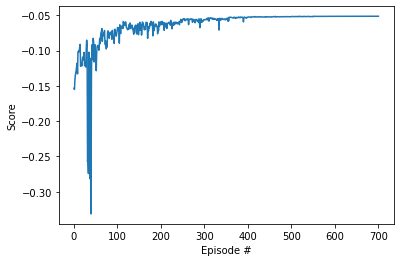

In [5]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores,best_actions = cem_no_net()
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
    

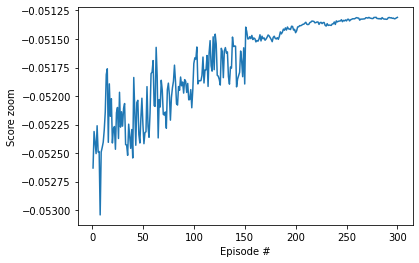

In [6]:

# plot the last scores zoom
fig = plt.figure()
zoom= 300
ax = fig.add_subplot(111)
plt.plot(np.arange(1, zoom+1), scores[-zoom:])
plt.ylabel('Score zoom')
plt.xlabel('Episode #')
plt.show()

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


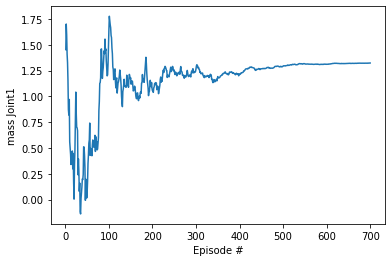

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


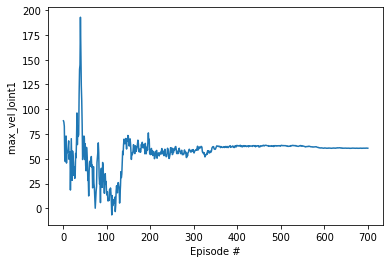

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


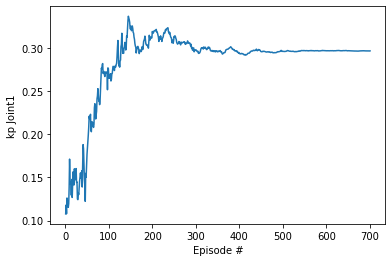

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


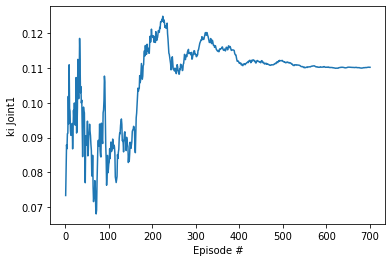

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


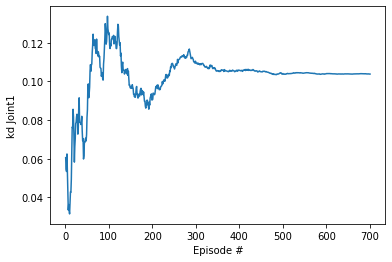

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


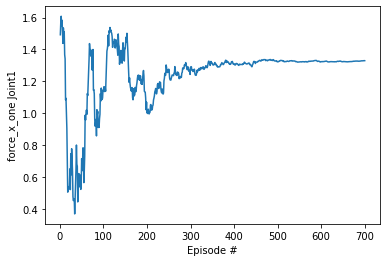

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


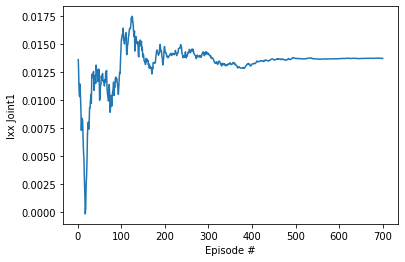

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


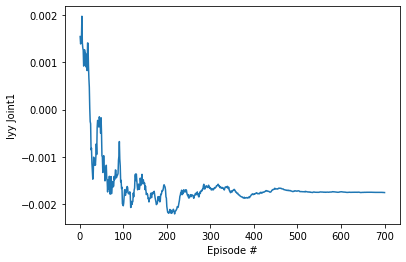

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


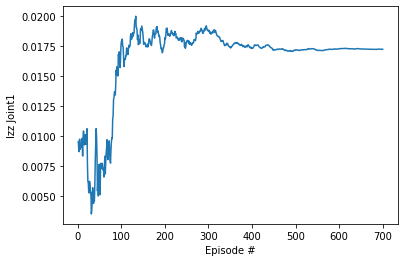

In [7]:
# plot actions
best_actions_np = np.array(best_actions)
joint = 1
for i in range(len(env.parameters_to_modify)) :
    parameter = env.parameters_to_modify[i]
    figures = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, best_actions_np.shape[0]+1), best_actions_np[:,joint+i*7])
    plt.ylabel(parameter+" Joint"+str(joint))
    plt.xlabel('Episode #')
    plt.show()

In [3]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excel_path_Okay_tcp = "./positions_from_joints_19.xlsx",time_step=0.05,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Make maxvels closer to the reality
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz","damping"])
env.robot.visual_inspection = False
env.modified_parameters_df = env.create_df_from_Excel("./Parameters_train_tcp_euc_rishabh.xlsx")


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous
print("trained",action)
reward = env.step_tcp_rishabh(action)
print("reward")
print(reward)



hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
mass okey
max_vel okey
kp okey
ki okey
kd okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
damping okey
original action: [1.377353, 1.163667, 1.16366, 0.930287, 0.678106, 0.678106, 0.500657, 168, 151, 128, 94, 210, 48, 189, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 1, 1, 1, 1, 1, 1, 1, 0.00480078220558528, 0.008418724123621643, 0.007544516197001279, 0.0064096919604697605, 0.0016797846804208455, 0.0019375935324615593, 0.0007750385804833523, 0.004755191268457921, 0.0019202057294098781, 0.007486605057526543, 0.0013804130332615912, 0.0015062421641084327, 0.0008273237988932355, 0.0005849825981943527, 0.0022826303695446856, 0.00836116845951151, 0.0019205500000651847, 0.006517816917001926, 0.0008260694053789821, 0.0017630597813546379, 0.0009751695712112207, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
trained [ 3.14743589e+00

In [4]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Train_parameters_result_tcp_euc_rishabh.xlsx")

[-0.01016801 -0.01826237 -0.05351549 -0.06081691 -0.1633701  -0.15192552
 -0.21736196 -0.15760384 -0.13320138 -0.08946645 -0.06102696 -0.05460613
 -0.08214024 -0.04180756  0.02633221 -0.00837314  0.03751877 -0.11814576
 -0.08311145 -0.12943665 -0.15819417 -0.16818427 -0.17261738 -0.15849957
 -0.16479458 -0.152148   -0.17217015 -0.16626718 -0.19153422 -0.1810759
 -0.19348248 -0.19106807 -0.17898843 -0.19301291 -0.16157906 -0.1904805
 -0.15814702 -0.17211376 -0.1360505  -0.14449655]


In [ ]:
env.original_parameters_df

In [ ]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excel_path_Okay_tcp = "./positions_from_joints_19.xlsx",time_step=0.05,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Make maxvels closer to the reality
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","kd","force_x_one","Ixx","Iyy","Izz"])
env.robot.visual_inspection = False
env.modified_parameters_df = env.original_parameters_df


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print(action)
reward = env.step_tcp_rishabh(action)

print("reward")
print(reward)

In [ ]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Original_parameters_result_tcp_euc_rishabh.xlsx")